In [23]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Helper function to calculate daily returns
def calculate_daily_returns(data):
    """
    Calculate daily percentage returns for stock data.
    """
    return data.pct_change().dropna()

# Collect and preprocess data for multiple stocks using yfinance
def get_portfolio_data(symbols, start_date="2015-01-01", end_date=None):
    """
    Fetch historical stock data and compute daily returns for multiple stocks.
    """
    if end_date is None:
        end_date = pd.Timestamp.now().strftime("%Y-%m-%d")

    portfolio_data = {}
    for symbol in symbols:
        try:
            print(f"Fetching data for {symbol}...")
            stock_data = yf.download(symbol, start=start_date, end=end_date)
            
            # Extract only the 'Close' prices
            stock_data = stock_data['Close']
            
            # Check the type of the data to ensure it's a Series
            if isinstance(stock_data, pd.DataFrame):
                stock_data = stock_data.iloc[:, 0]  # Get the first column if it's a DataFrame
            elif not isinstance(stock_data, pd.Series):
                print(f"Warning: Invalid data format for {symbol}. Skipping...")
                continue

            # Debugging: print raw data for each stock
            print(f"Raw data for {symbol}:")
            print(stock_data.head())
            
            # Check if the data is empty or malformed
            if stock_data.empty:
                print(f"Warning: No data found for {symbol}. Skipping...")
                continue

            print(f"Data for {symbol} fetched successfully. Processing...")
            daily_returns = calculate_daily_returns(stock_data)
            portfolio_data[symbol] = daily_returns
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
            continue

    # Return DataFrame or raise error if no valid data was fetched
    if portfolio_data:
        return pd.DataFrame(portfolio_data)
    else:
        raise ValueError("No valid data fetched for any symbols.")

# Portfolio Optimization
def optimize_portfolio(returns):
    """
    Optimize portfolio using Modern Portfolio Theory and Sharpe Ratio.
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    num_assets = len(mean_returns)

    # Objective function: negative Sharpe Ratio (since we minimize)
    def neg_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -portfolio_return / portfolio_stddev

    # Constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # Bounds: weights between 0 and 1
    bounds = tuple((0, 1) for _ in range(num_assets))
    # Initial guess: equal allocation
    initial_weights = num_assets * [1.0 / num_assets]

    result = minimize(neg_sharpe, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Generate Insights and Explainability
def interpret_results(weights, symbols, returns):
    """
    Analyze and explain the portfolio allocation.
    """
    portfolio_return = np.dot(weights, returns.mean()) * 252  # Annualized return
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights))) * np.sqrt(252)  # Annualized stddev
    sharpe_ratio = portfolio_return / portfolio_stddev

    # Format results to match desired output
    print("\nOptimal Portfolio Allocation:")
    for symbol, weight in zip(symbols, weights):
        print(f"{symbol}: {weight*100:.2f}%")  # Format as percentage

    print(f"\nExpected Annual Return: {portfolio_return*100:.2f}%")
    print(f"Annualized Volatility (Risk): {portfolio_stddev*100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

    return {"weights": weights, "return": portfolio_return, "risk": portfolio_stddev, "sharpe_ratio": sharpe_ratio}

# Neutral Strategy
def neutral_strategy(returns, weights):
    """
    Adjust the portfolio to minimize market exposure.
    """
    neutral_weights = weights - np.mean(weights)  # Neutralize weights around the mean
    portfolio_return = np.dot(neutral_weights, returns.mean()) * 252
    portfolio_stddev = np.sqrt(np.dot(neutral_weights.T, np.dot(returns.cov(), neutral_weights))) * np.sqrt(252)

    # Format results to match desired output
    print("\nNeutral Strategy Adjustments:")
    for symbol, weight in zip(returns.columns, neutral_weights):
        print(f"{symbol}: {weight*100:.2f}%")  # Format as percentage

    print(f"\nNeutralized Return: {portfolio_return*100:.2f}%")
    print(f"Neutralized Volatility (Risk): {portfolio_stddev*100:.2f}%")

    return neutral_weights, portfolio_return, portfolio_stddev

# Run the full pipeline
if __name__ == "__main__":
    STOCK_SYMBOLS = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
    START_DATE = "2015-01-01"
    
    try:
        # Step 1: Get portfolio data
        portfolio_returns = get_portfolio_data(STOCK_SYMBOLS, start_date=START_DATE)

        # Step 2: Optimize portfolio using MPT and Sharpe Ratio
        optimal_weights = optimize_portfolio(portfolio_returns)

        # Step 3: Interpret the results
        interpret_results(optimal_weights, portfolio_returns.columns, portfolio_returns)

        # Step 4: Apply Neutral Strategy
        neutral_weights, neutral_return, neutral_risk = neutral_strategy(portfolio_returns, optimal_weights)

    except Exception as e:
        print(f"Error: {e}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching data for AAPL...
Raw data for AAPL:
Date
2015-01-02 00:00:00+00:00    27.332500
2015-01-05 00:00:00+00:00    26.562500
2015-01-06 00:00:00+00:00    26.565001
2015-01-07 00:00:00+00:00    26.937500
2015-01-08 00:00:00+00:00    27.972500
Name: AAPL, dtype: float64
Data for AAPL fetched successfully. Processing...
Fetching data for MSFT...
Raw data for MSFT:
Date
2015-01-02 00:00:00+00:00    46.759998
2015-01-05 00:00:00+00:00    46.330002
2015-01-06 00:00:00+00:00    45.650002
2015-01-07 00:00:00+00:00    46.230000
2015-01-08 00:00:00+00:00    47.590000
Name: MSFT, dtype: float64
Data for MSFT fetched successfully. Processing...
Fetching data for GOOGL...
Raw data for GOOGL:
Date
2015-01-02 00:00:00+00:00    26.477501
2015-01-05 00:00:00+00:00    25.973000
2015-01-06 00:00:00+00:00    25.332001
2015-01-07 00:00:00+00:00    25.257500
2015-01-08 00:00:00+00:00    25.345501
Name: GOOGL, dtype: float64
Data for GOOGL fetched successfully. Processing...
Fetching data for AMZN...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Raw data for AMZN:
Date
2015-01-02 00:00:00+00:00    15.4260
2015-01-05 00:00:00+00:00    15.1095
2015-01-06 00:00:00+00:00    14.7645
2015-01-07 00:00:00+00:00    14.9210
2015-01-08 00:00:00+00:00    15.0230
Name: AMZN, dtype: float64
Data for AMZN fetched successfully. Processing...
Fetching data for TSLA...
Raw data for TSLA:
Date
2015-01-02 00:00:00+00:00    14.620667
2015-01-05 00:00:00+00:00    14.006000
2015-01-06 00:00:00+00:00    14.085333
2015-01-07 00:00:00+00:00    14.063333
2015-01-08 00:00:00+00:00    14.041333
Name: TSLA, dtype: float64
Data for TSLA fetched successfully. Processing...

Optimal Portfolio Allocation:
AAPL: 23.04%
MSFT: 26.61%
GOOGL: 0.00%
AMZN: 31.73%
TSLA: 18.63%

Expected Annual Return: 31.72%
Annualized Volatility (Risk): 27.62%
Sharpe Ratio: 1.15

Neutral Strategy Adjustments:
AAPL: 3.04%
MSFT: 6.61%
GOOGL: -20.00%
AMZN: 11.73%
TSLA: -1.37%

Neutralized Return: 0.97%
Neutralized Volatility (Risk): 4.13%


In [66]:

# Helper function to calculate daily returns
def calculate_daily_returns(data):
    """
    Calculate daily percentage returns for stock data.
    """
    return data.pct_change().dropna()

# Collect and preprocess data for multiple stocks using yfinance
def get_portfolio_data(symbols, start_date="2015-01-01", end_date=None):
    """
    Fetch historical stock data and compute daily returns for multiple stocks.
    """
    if end_date is None:
        end_date = pd.Timestamp.now().strftime("%Y-%m-%d")

    portfolio_data = {}
    for symbol in symbols:
        try:
            print(f"Fetching data for {symbol}...")
            stock_data = yf.download(symbol, start=start_date, end=end_date)
            
            # Extract only the 'Close' prices
            stock_data = stock_data['Close']
            
            # Check the type of the data to ensure it's a Series
            if isinstance(stock_data, pd.DataFrame):
                stock_data = stock_data.iloc[:, 0]  # Get the first column if it's a DataFrame
            elif not isinstance(stock_data, pd.Series):
                print(f"Warning: Invalid data format for {symbol}. Skipping...")
                continue

            # Check if the data is empty or malformed
            if stock_data.empty:
                print(f"Warning: No data found for {symbol}. Skipping...")
                continue

            print(f"Data for {symbol} fetched successfully. Processing...")
            daily_returns = calculate_daily_returns(stock_data)
            portfolio_data[symbol] = daily_returns
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
            continue

    # Return DataFrame or raise error if no valid data was fetched
    if portfolio_data:
        return pd.DataFrame(portfolio_data)
    else:
        raise ValueError("No valid data fetched for any symbols.")

# Portfolio Optimization with Transaction Costs
def optimize_portfolio(returns, transaction_cost=0.002):
    """
    Optimize portfolio using Modern Portfolio Theory and Sharpe Ratio, including transaction costs.
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    num_assets = len(mean_returns)

    # Objective function: negative Sharpe Ratio (since we minimize)
    def neg_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        # Transaction cost impact: cost based on absolute weight change
        transaction_costs = np.sum(np.abs(weights - initial_weights)) * transaction_cost
        
        return -portfolio_return / portfolio_stddev + transaction_costs  # Add transaction costs to the objective

    # Constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # Bounds: weights between 0 and 1
    bounds = tuple((0, 1) for _ in range(num_assets))
    # Initial guess: equal allocation
    initial_weights = num_assets * [1.0 / num_assets]

    result = minimize(neg_sharpe, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Generate Insights and Explainability
def interpret_results(weights, symbols, returns, initial_weights, transaction_cost=0.002):
    """
    Analyze and explain the portfolio allocation with transaction costs.
    """
    portfolio_return = np.dot(weights, returns.mean()) * 252  # Annualized return
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights))) * np.sqrt(252)  # Annualized stddev
    sharpe_ratio = portfolio_return / portfolio_stddev

    # Transaction cost adjustment
    transaction_costs = np.sum(np.abs(weights - initial_weights)) * transaction_cost
    expected_return_after_costs = portfolio_return - transaction_costs
    
    # Format results to match desired output
    print("\nOptimal Portfolio Allocation (with transaction cost):")
    for symbol, weight in zip(symbols, weights):
        print(f"{symbol}: {weight*100:.2f}%")  # Format as percentage

    print(f"\nExpected Annual Return (before costs): {portfolio_return*100:.2f}%")
    print(f"Annualized Volatility (Risk): {portfolio_stddev*100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Estimated Transaction Costs: {transaction_costs*100:.2f}%")
    print(f"Expected Annual Return (after costs): {expected_return_after_costs*100:.2f}%")

    return {"weights": weights, "return": portfolio_return, "risk": portfolio_stddev, "sharpe_ratio": sharpe_ratio, "transaction_costs": transaction_costs}

# Run the full pipeline
if __name__ == "__main__":
    STOCK_SYMBOLS = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
    START_DATE = "2015-01-01"
    
    try:
        # Step 1: Get portfolio data
        portfolio_returns = get_portfolio_data(STOCK_SYMBOLS, start_date=START_DATE)

        # Step 2: Optimize portfolio using MPT and Sharpe Ratio with transaction cost
        initial_weights = np.array([1.0 / len(STOCK_SYMBOLS)] * len(STOCK_SYMBOLS))  # Equal initial allocation
        optimal_weights = optimize_portfolio(portfolio_returns)

        # Step 3: Interpret the results, including transaction costs
        interpret_results(optimal_weights, portfolio_returns.columns, portfolio_returns, initial_weights)

    except Exception as e:
        print(f"Error: {e}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching data for AAPL...
Data for AAPL fetched successfully. Processing...
Fetching data for MSFT...
Data for MSFT fetched successfully. Processing...
Fetching data for GOOGL...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data for GOOGL fetched successfully. Processing...
Fetching data for AMZN...
Data for AMZN fetched successfully. Processing...
Fetching data for TSLA...
Data for TSLA fetched successfully. Processing...

Optimal Portfolio Allocation (with transaction cost):
AAPL: 20.37%
MSFT: 20.76%
GOOGL: 8.45%
AMZN: 30.43%
TSLA: 19.99%

Expected Annual Return (before costs): 31.69%
Annualized Volatility (Risk): 27.69%
Sharpe Ratio: 1.14
Estimated Transaction Costs: 0.05%
Expected Annual Return (after costs): 31.64%


In [67]:

# Helper function to calculate daily returns
def calculate_daily_returns(data):
    return data.pct_change().dropna()

# Collect and preprocess data for multiple stocks using yfinance
def get_portfolio_data(symbols, start_date="2015-01-01", end_date=None):
    if end_date is None:
        end_date = pd.Timestamp.now().strftime("%Y-%m-%d")

    portfolio_data = {}
    for symbol in symbols:
        try:
            print(f"Fetching data for {symbol}...")
            stock_data = yf.download(symbol, start=start_date, end=end_date)
            stock_data = stock_data['Close']
            
            if isinstance(stock_data, pd.DataFrame):
                stock_data = stock_data.iloc[:, 0]
            elif not isinstance(stock_data, pd.Series):
                print(f"Warning: Invalid data format for {symbol}. Skipping...")
                continue

            if stock_data.empty:
                print(f"Warning: No data found for {symbol}. Skipping...")
                continue

            daily_returns = calculate_daily_returns(stock_data)
            portfolio_data[symbol] = daily_returns
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
            continue

    if portfolio_data:
        return pd.DataFrame(portfolio_data)
    else:
        raise ValueError("No valid data fetched for any symbols.")

# Portfolio Optimization
def optimize_portfolio(returns):
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    num_assets = len(mean_returns)

    def neg_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -portfolio_return / portfolio_stddev

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_weights = num_assets * [1.0 / num_assets]

    result = minimize(neg_sharpe, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Calculate transaction costs
def calculate_transaction_costs(initial_weights, optimal_weights, transaction_cost_rate=0.001):
    transaction_cost = np.sum(np.abs(optimal_weights - initial_weights)) * transaction_cost_rate
    return transaction_cost

# Generate Insights and Explainability
def interpret_results(weights, symbols, returns, initial_weights=None, transaction_cost_rate=0.001):
    portfolio_return = np.dot(weights, returns.mean()) * 252  # Annualized return
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights))) * np.sqrt(252)  # Annualized stddev
    sharpe_ratio = portfolio_return / portfolio_stddev

    if initial_weights is not None:
        transaction_cost = calculate_transaction_costs(initial_weights, weights, transaction_cost_rate)
        expected_return_after_costs = portfolio_return - transaction_cost
        print(f"Estimated Transaction Costs: {transaction_cost * 100:.2f}%")
        print(f"Expected Annual Return (after costs): {expected_return_after_costs * 100:.2f}%")
    else:
        print(f"Expected Annual Return (before costs): {portfolio_return * 100:.2f}%")

    print(f"Annualized Volatility (Risk): {portfolio_stddev * 100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

    return {"weights": weights, "return": portfolio_return, "risk": portfolio_stddev, "sharpe_ratio": sharpe_ratio}

# Run the full pipeline
if __name__ == "__main__":
    STOCK_SYMBOLS = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
    START_DATE = "2015-01-01"
    
    try:
        # Step 1: Get portfolio data
        portfolio_returns = get_portfolio_data(STOCK_SYMBOLS, start_date=START_DATE)

        # Step 2: Optimize portfolio using MPT and Sharpe Ratio
        initial_weights = np.ones(len(STOCK_SYMBOLS)) / len(STOCK_SYMBOLS)  # Equal initial weights
        optimal_weights = optimize_portfolio(portfolio_returns)

        # Step 3: Interpret the results with transaction costs
        interpret_results(optimal_weights, portfolio_returns.columns, portfolio_returns, initial_weights)

    except Exception as e:
        print(f"Error: {e}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching data for AAPL...
Fetching data for MSFT...
Fetching data for GOOGL...
Fetching data for AMZN...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching data for TSLA...
Estimated Transaction Costs: 0.04%
Expected Annual Return (after costs): 31.68%
Annualized Volatility (Risk): 27.62%
Sharpe Ratio: 1.15


In [55]:
constraints = [
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Weights sum to 1
    {'type': 'ineq', 'fun': lambda x: x[0] - 0.1},   # Ensure at least 10% in AAPL
    {'type': 'ineq', 'fun': lambda x: 0.5 - np.sum(x)}  # Limit total weight to <=50% for specific sectors
]

In [ ]:

# Helper function to calculate daily returns
def calculate_daily_returns(data):
    return data.pct_change().dropna()

# Collect and preprocess data for multiple stocks using yfinance
def get_portfolio_data(symbols, start_date="2015-01-01", end_date=None):
    if end_date is None:
        end_date = pd.Timestamp.now().strftime("%Y-%m-%d")

    portfolio_data = {}
    for symbol in symbols:
        try:
            print(f"Fetching data for {symbol}...")
            stock_data = yf.download(symbol, start=start_date, end=end_date)
            stock_data = stock_data['Close']
            
            if isinstance(stock_data, pd.DataFrame):
                stock_data = stock_data.iloc[:, 0]
            elif not isinstance(stock_data, pd.Series):
                print(f"Warning: Invalid data format for {symbol}. Skipping...")
                continue

            if stock_data.empty:
                print(f"Warning: No data found for {symbol}. Skipping...")
                continue

            daily_returns = calculate_daily_returns(stock_data)
            portfolio_data[symbol] = daily_returns
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
            continue

    if portfolio_data:
        return pd.DataFrame(portfolio_data)
    else:
        raise ValueError("No valid data fetched for any symbols.")

# Portfolio Optimization
def optimize_portfolio(returns):
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    num_assets = len(mean_returns)

    def neg_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -portfolio_return / portfolio_stddev

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_weights = num_assets * [1.0 / num_assets]

    result = minimize(neg_sharpe, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Calculate transaction costs
def calculate_transaction_costs(initial_weights, optimal_weights, transaction_cost_rate=0.001):
    transaction_cost = np.sum(np.abs(optimal_weights - initial_weights)) * transaction_cost_rate
    return transaction_cost

# Generate Insights and Explainability
def interpret_results(weights, symbols, returns, initial_weights=None, transaction_cost_rate=0.001):
    portfolio_return = np.dot(weights, returns.mean()) * 252  # Annualized return
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights))) * np.sqrt(252)  # Annualized stddev
    sharpe_ratio = portfolio_return / portfolio_stddev

    if initial_weights is not None:
        transaction_cost = calculate_transaction_costs(initial_weights, weights, transaction_cost_rate)
        expected_return_after_costs = portfolio_return - transaction_cost
        print(f"Optimal Portfolio Allocation (with transaction cost):")
        for i, symbol in enumerate(symbols):
            print(f"{symbol}: {weights[i] * 100:.2f}%")
        print(f"Expected Annual Return (before costs): {portfolio_return * 100:.2f}%")
        print(f"Annualized Volatility (Risk): {portfolio_stddev * 100:.2f}%")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Estimated Transaction Costs: {transaction_cost * 100:.2f}%")
        print(f"Expected Annual Return (after costs): {expected_return_after_costs * 100:.2f}%\n")
    else:
        print(f"Expected Annual Return (before costs): {portfolio_return * 100:.2f}%")
        print(f"Annualized Volatility (Risk): {portfolio_stddev * 100:.2f}%")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Run the full pipeline
if __name__ == "__main__":
    STOCK_SYMBOLS = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
    START_DATE = "2015-01-01"
    
    try:
        # Step 1: Get portfolio data
        portfolio_returns = get_portfolio_data(STOCK_SYMBOLS, start_date=START_DATE)

        # Step 2: Optimize portfolio using MPT and Sharpe Ratio
        initial_weights = np.ones(len(STOCK_SYMBOLS)) / len(STOCK_SYMBOLS)  # Equal initial weights
        optimal_weights = optimize_portfolio(portfolio_returns)

        # Step 3: Interpret the results with varying transaction costs
        transaction_costs = [0.0001, 0.0005, 0.001, 0.005]  # Different transaction costs for each iteration
        
        for cost in transaction_costs:
            interpret_results(optimal_weights, portfolio_returns.columns, portfolio_returns, initial_weights, transaction_cost_rate=cost)

    except Exception as e:
        print(f"Error: {e}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching data for AAPL...
Fetching data for MSFT...
Fetching data for GOOGL...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

In [60]:
# Simulate stressed returns
stressed_returns = portfolio_returns * np.random.normal(0.9, 0.2, size=portfolio_returns.shape)  # Simulate stress

# Optimize portfolio without passing the risk_free_rate argument
optimal_weights_stressed = optimize_portfolio(stressed_returns)

# Interpret results
interpret_results(optimal_weights_stressed, STOCK_SYMBOLS, stressed_returns)


Expected Annual Return (before costs): 29.57%
Annualized Volatility (Risk): 25.23%
Sharpe Ratio: 1.17


[*********************100%***********************]  5 of 5 completed


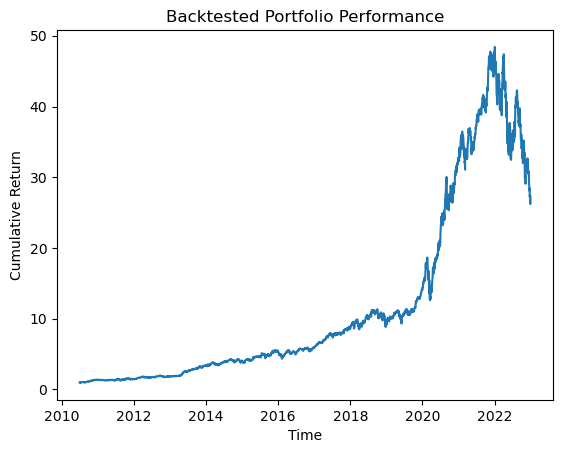

In [62]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define stock symbols and weights (example)
STOCK_SYMBOLS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
optimal_weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # Example equal weights for simplicity

# Fetch historical data for the given stock symbols
def get_portfolio_data(symbols, start_date='2010-01-01', end_date='2023-01-01'):
    data = yf.download(symbols, start=start_date, end=end_date)['Adj Close']
    return data

# Fetch historical data for portfolio
historical_data = get_portfolio_data(STOCK_SYMBOLS)

# Calculate historical returns (daily returns)
historical_returns = historical_data.pct_change().dropna()

# Calculate the portfolio returns based on optimal weights
portfolio_returns = (historical_returns * optimal_weights).sum(axis=1)

# Calculate cumulative returns for the portfolio
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plot the cumulative returns
plt.plot(cumulative_returns)
plt.title("Backtested Portfolio Performance")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.show()


[*********************100%***********************]  9 of 9 completed


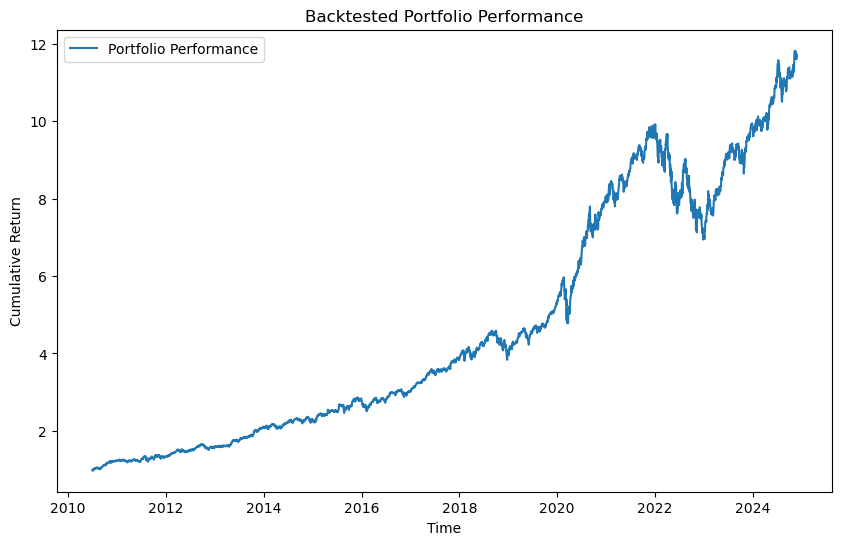

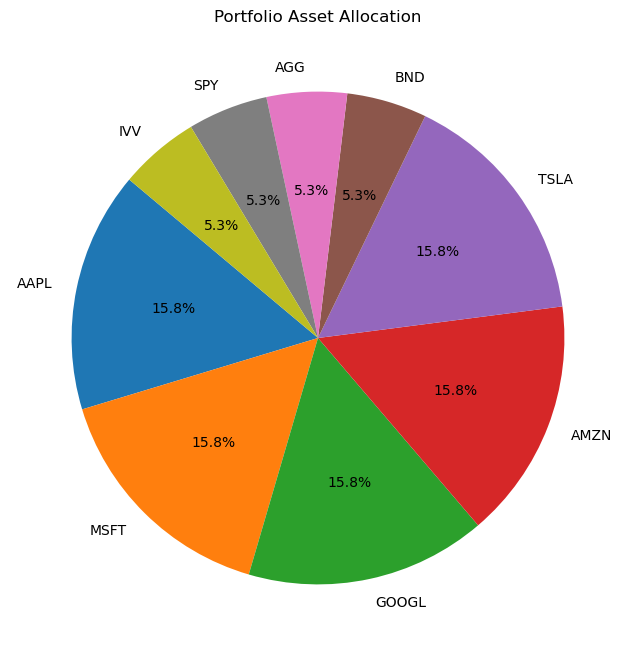

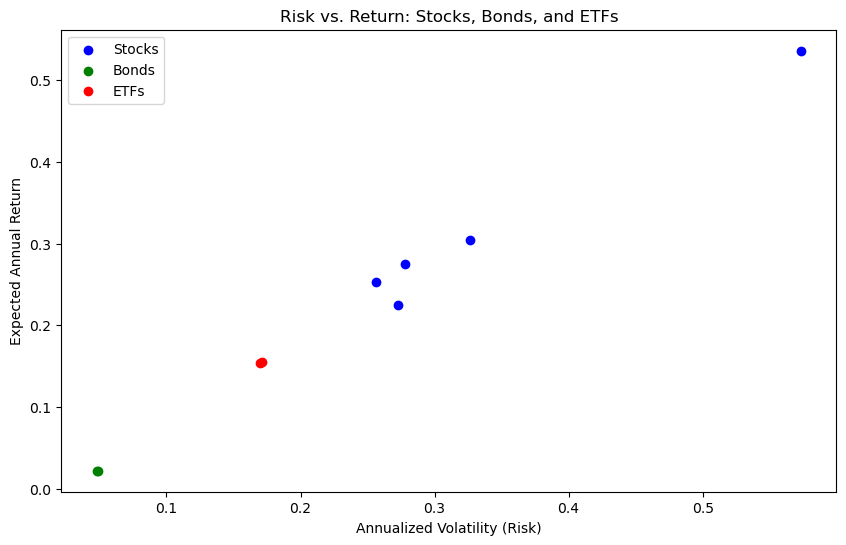

[*********************100%***********************]  1 of 1 completed


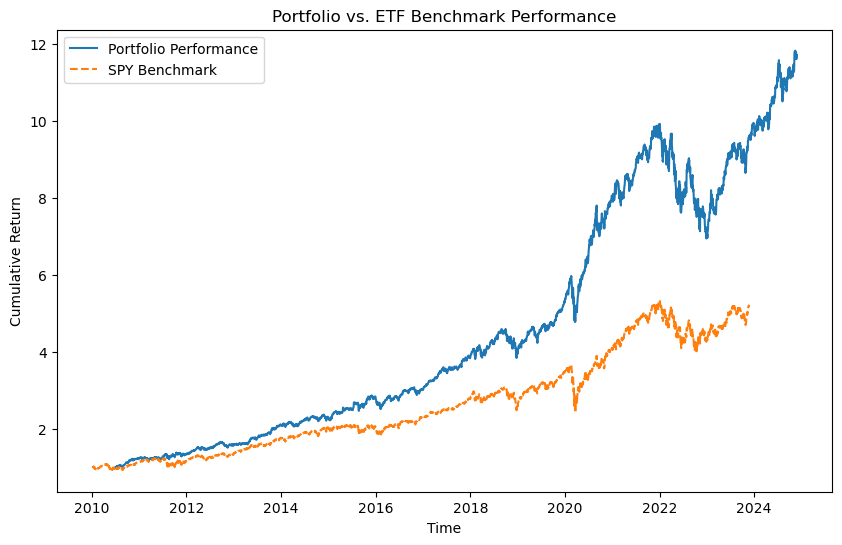

In [65]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define stock symbols and weights (with bonds and ETFs added)
STOCK_SYMBOLS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
BOND_SYMBOLS = ['BND', 'AGG']  # Example bond ETFs
ETF_SYMBOLS = ['SPY', 'IVV']  # Example stock ETFs

# Combine all symbols into one list
ALL_SYMBOLS = STOCK_SYMBOLS + BOND_SYMBOLS + ETF_SYMBOLS

# Example portfolio weights (split between stocks, bonds, and ETFs)
optimal_weights = np.array([0.15, 0.15, 0.15, 0.15, 0.15, 0.05, 0.05, 0.05, 0.05])  # Adjust the weights as needed

# Fetch historical data for the given stock symbols, bonds, and ETFs
def get_portfolio_data(symbols, start_date='2010-01-01', end_date='2024-11-26'):  # Corrected date format
    data = yf.download(symbols, start=start_date, end=end_date)['Adj Close']
    return data

# Fetch historical data for portfolio (stocks, bonds, ETFs)
historical_data = get_portfolio_data(ALL_SYMBOLS)

# Calculate historical returns (daily returns)
historical_returns = historical_data.pct_change().dropna()

# Calculate the portfolio returns based on optimal weights
portfolio_returns = (historical_returns * optimal_weights).sum(axis=1)

# Calculate cumulative returns for the portfolio
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label="Portfolio Performance")
plt.title("Backtested Portfolio Performance")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

# Visualization: Portfolio Composition (Pie chart)
labels = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'BND', 'AGG', 'SPY', 'IVV']
plt.figure(figsize=(8, 8))
plt.pie(optimal_weights, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Portfolio Asset Allocation")
plt.show()

# Scatter Plot: Risk vs. Return (Volatility vs. Annual Return)
# Calculate expected annual returns and volatility (standard deviation) for each asset class
annual_returns = historical_returns.mean() * 252  # 252 trading days in a year
volatility = historical_returns.std() * np.sqrt(252)

# Plot risk-return scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(volatility[STOCK_SYMBOLS], annual_returns[STOCK_SYMBOLS], label="Stocks", color='blue')
plt.scatter(volatility[BOND_SYMBOLS], annual_returns[BOND_SYMBOLS], label="Bonds", color='green')
plt.scatter(volatility[ETF_SYMBOLS], annual_returns[ETF_SYMBOLS], label="ETFs", color='red')

plt.title("Risk vs. Return: Stocks, Bonds, and ETFs")
plt.xlabel("Annualized Volatility (Risk)")
plt.ylabel("Expected Annual Return")
plt.legend()
plt.show()

# Performance Comparison: Portfolio vs. ETF Benchmark
# Use SPY as a benchmark ETF (e.g., S&P 500)
benchmark_data = yf.download('SPY', start='2010-01-01', end='2023-11-26')['Adj Close']  # Corrected date format
benchmark_returns = benchmark_data.pct_change().dropna()
benchmark_cumulative_returns = (1 + benchmark_returns).cumprod()

# Plot performance comparison
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label="Portfolio Performance")
plt.plot(benchmark_cumulative_returns, label="SPY Benchmark", linestyle='--')
plt.title("Portfolio vs. ETF Benchmark Performance")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()
